# **Efficient Quantized Vector Ingestion with Cohere and MongoDB**


---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/mongodb-developer/GenAI-Showcase/blob/main/notebooks/advanced_techniques/quantized_vector_ingestion_with_cohere_and_mongodb.ipynb)


You can view an article version of this notebook here:

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://mdb.link/quantized_vector_ingestion_cohere)


In this notebook, we cover the following:

- What are quantization and vector quantization?
- Example of scalar quantization
- Efficient quantized vector ingestion with Cohere and MongoDB
- Comparison of float32, BSON float32, and BSON int8 embeddings in vector search operations
- Practical considerations for choosing the right embedding format for your AI application

# **Prerequisute: Understanding Scalar Quantization**

Vector quantization is a lossy compression algorithm designed to reduce the dimensionality and memory requirements of high-dimensional vector data. It achieves this by mapping the original vectors to a smaller set of representative vectors. This process allows for significant data compression while preserving much of the essential information contained in the original vectors. Vector quantization technique is particularly useful in AI applications where some loss of precision is acceptable in exchange for reduced storage needs and lower latency in data retrieval steps.
Let's demonstrate vector quantization using float32 values and quantizing to 8-bit integers. We'll use a simplified example with 1D vectors for clarity.

```
Float32: [1.23, 4.56, 2.34, 5.67, 3.45, 6.78, 1.89, 4.90]
```
```
Int8: [0, 153, 51, 204, 102, 255, 30, 169]
```
Step 1:  Determine the range of values.
```
Min: 1.23
Max: 6.78
```
Step 2: Define the quantization scale
```
Scale = (Max - Min) / 255 = (6.78 - 1.23) / 255 ≈ 0.0217
```
Step 3: Quantize to 8-bit integers using the formula below:
```quantized = round((original - Min) / Scale)```


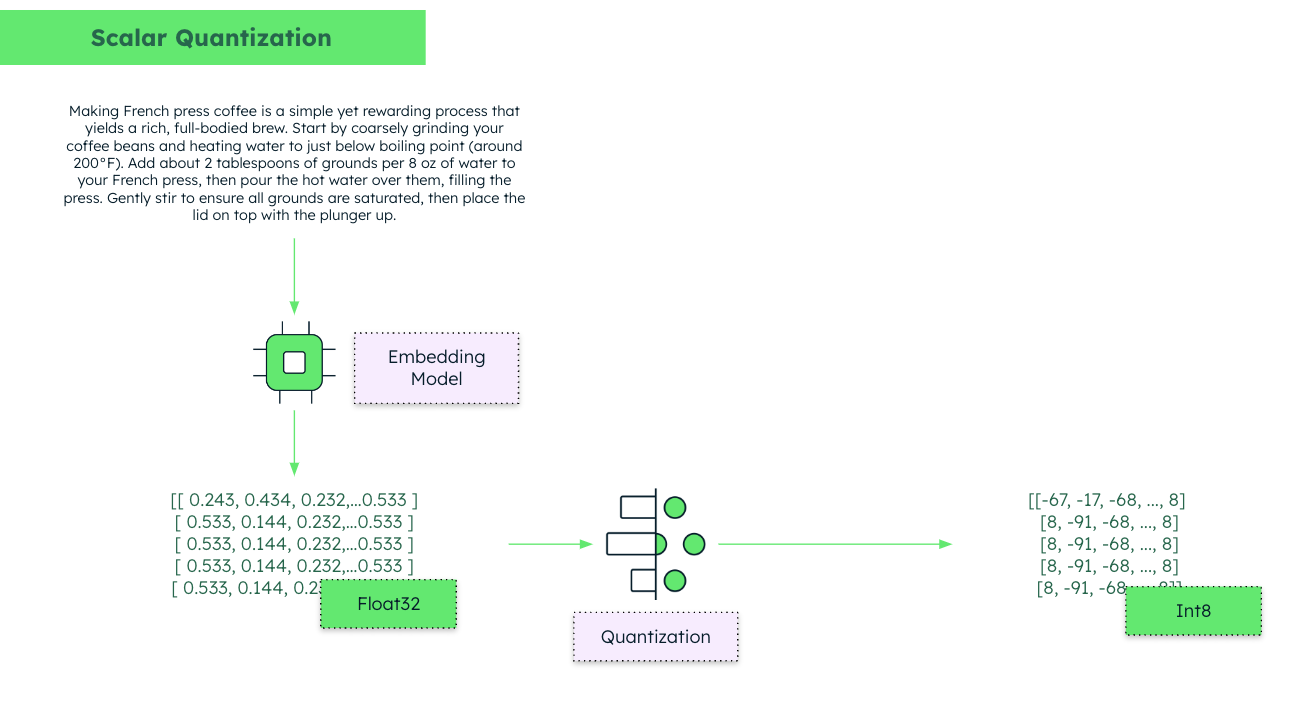

In [ ]:
import numpy as np


def quantize_vector(vector, bits=8):
    """Quantize a float32 vector to n-bit integers."""

    # Convert the vector to a numpy array
    vector = np.array(vector, dtype=np.float32)

    # Step 1: Determine the range of values.
    min_val, max_val = vector.min(), vector.max()

    # Step 2: Define the quantization scale
    scale = (max_val - min_val) / (2**bits - 1)

    # Step 3: Quantize to 8-bit integers using the formula below: quantized = round((original - Min) / Scale)
    quantized = np.round((vector - min_val) / scale).astype(np.uint8)

    return quantized, min_val, scale


def dequantize_vector(quantized, min_val, scale, bits=8):
    """Dequantize the vector back to float32."""
    return (quantized.astype(np.float32) * scale) + min_val


# Original float32 vector
original = np.array([1.23, 4.56, 2.34, 5.67, 3.45, 6.78, 1.89, 4.90], dtype=np.float32)

# Run Quantize
quantized, min_val, scale = quantize_vector(original)

# Dequantize (reconstruct)
reconstructed = dequantize_vector(quantized, min_val, scale)

# Print results
print("Original (float32):")
print(original)
print("\nQuantized (uint8):")
print(quantized)
print(f"\nQuantization parameters - Min: {min_val}, Scale: {scale}")
print("\nReconstructed (float32):")
print(reconstructed)
print("\nMean Absolute Error:")
print(np.mean(np.abs(original - reconstructed)))

# Memory usage
print(f"\nOriginal memory usage: {original.nbytes} bytes")
print(f"Quantized memory usage: {quantized.nbytes} bytes")
print(f"Compression ratio: {original.nbytes / quantized.nbytes:.2f}x")

Original (float32):
[1.23 4.56 2.34 5.67 3.45 6.78 1.89 4.9 ]

Quantized (uint8):
[  0 153  51 204 102 255  30 169]

Quantization parameters - Min: 1.2300000190734863, Scale: 0.021764706630332798

Reconstructed (float32):
[1.23      4.5600004 2.3400002 5.67      3.45      6.78      1.8829412
 4.9082355]

Mean Absolute Error:
0.0019118637

Original memory usage: 32 bytes
Quantized memory usage: 8 bytes
Compression ratio: 4.00x


# **What we are building**

This section provides a comprehensive guide to implementing efficient quantized vector ingestion and search using Cohere and MongoDB. We'll walk through the entire process, from generating quantized and non-quantized embeddings with Cohere's API to converting them into BSON format, ingesting them into MongoDB, and performing vector searches on the stored embeddings.


The end result of this section is a fully functional system that demonstrates the practical implementation of quantized vector storage and retrieval. This setup will allow you to compare the performance and accuracy of different embedding types (float32, BSON float32, and BSON int8) in vector search operations.

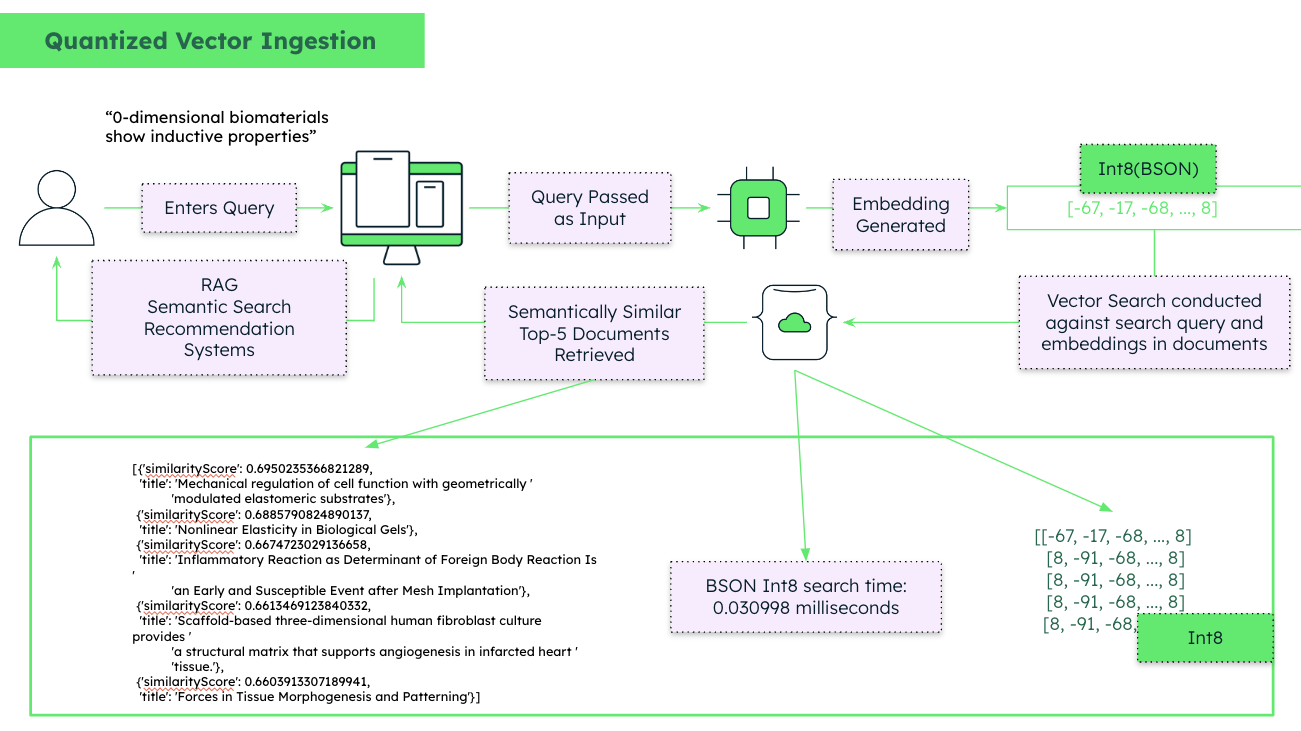

# **Step 1: Install Libraries and Set Environment Variables**

For the code implementation in this tutorial, the following libraries are utilized:
- `pandas`:  A data manipulation library for efficient handling of structured data. It's used for loading, cleaning, transforming, and analyzing data in various formats.
- `cohere`: The official Cohere Python library. It will provide access to advanced language models, embedding generation, and text generation.
- `pymongo`: The official Python driver for MongoDB. While commented out in the installation, it suggests potential use for interacting with MongoDB databases, enabling storage and retrieval of data.



In [ ]:
!pip install --quiet --upgrade pandas cohere pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 k

[Click here to get your Cohere API Key](https://dashboard.cohere.com/api-keys)

In [ ]:
import getpass
import os

import cohere

COHERE_API_KEY = getpass.getpass("Enter Cohere API Key: ")
os.environ["COHERE_API_KEY"] = COHERE_API_KEY

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Enter Cohere API Key: ··········


# **Step 2: Data Loading**

This step involves generating a small structured dataset of sentences with placeholder fields for various embedding types. The dataset is designed to facilitate the demonstration and comparison of different embedding techniques in natural language processing and database storage.

The data is structured as a list of dictionaries, where each dictionary represents a sentence and its associated embedding attributes. Each entry contains a `sentence` key with a factual statement as its value, along with four embedding-related keys: `float32_embedding`, `int8_embedding`, `bson_float32_embedding`, and `bson_int8_embedding`. These keys are initially set to `None`.

In [ ]:
sentences = [
    {
        "sentence": "Water boils at 100 degrees Celsius at standard atmospheric pressure.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The Great Wall of China is visible from space.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Photosynthesis converts light energy into chemical energy in plants.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "DNA contains the genetic instructions for all living organisms.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Jupiter is the largest planet in our solar system.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The Eiffel Tower was completed in Paris in 1889.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Honey never spoils due to its unique chemical properties.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The human body contains approximately 206 bones in adulthood.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Mount Everest is the highest peak on Earth at 8,848m.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Shakespeare wrote 37 plays and 154 sonnets during his lifetime.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The speed of light in vacuum is 299,792,458 meters/second.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Penguins are flightless birds found primarily in the Southern Hemisphere.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The Mona Lisa was painted by Leonardo da Vinci.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Oxygen makes up about 21% of Earth's atmosphere by volume.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The American Civil War lasted from 1861 to 1865.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Antibiotics are ineffective against viral infections like the common cold.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The human heart beats approximately 100,000 times per day.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "Gold is one of the least reactive chemical elements.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "The first successful powered aircraft flew in 1903.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
    {
        "sentence": "There are 118 elements in the periodic table.",
        "float32_embedding": None,
        "int8_embedding": None,
        "bson_float32_embedding": None,
        "bson_int8_embedding": None,
    },
]

In [ ]:
import pandas as pd

# Convert the list of dictionaries into a pandas DataFrame
sentences_df = pd.DataFrame(sentences)

In [ ]:
sentences_df.head()

,sentence,float32_embedding,int8_embedding,bson_float32_embedding,bson_int8_embedding
0,Water boils at 100 degrees Celsius at standard...,None,None,None,None
1,The Great Wall of China is visible from space.,None,None,None,None
2,Photosynthesis converts light energy into chem...,None,None,None,None
3,DNA contains the genetic instructions for all ...,None,None,None,None
4,Jupiter is the largest planet in our solar sys...,None,None,None,None


# **Step 3: Embedding Generation With Cohere**

This step demonstrates the process of generating embeddings for our sentence dataset using the Cohere API. We will define a custom function, `get_cohere_embeddings`, for efficient embedding generation.


In [ ]:
# Initialize Cohere Client
co = cohere.Client(COHERE_API_KEY)

In [ ]:
from typing import List, Tuple


def get_cohere_embeddings(sentences: List[str]) -> Tuple[List[float], List[int]]:
    """
    Generates embeddings for the provided sentences using Cohere's embedding model.

    Args:
        sentences (list of str): List of sentences to generate embeddings for.

    Returns:
      list: A list of embeddings, where each embedding corresponds to a sentence.
            The embeddings are generated using the "embed-english-v3.0" model and include both
            float and int8 types.
    """
    genereated_embedding = co.embed(
        texts=sentences,
        model="embed-english-v3.0",
        input_type="search_document",
        embedding_types=["float", "int8"],
    ).embeddings

    return genereated_embedding.float, genereated_embedding.int8

In [ ]:
# Iterate through each row in the DataFrame
for index, row in sentences_df.iterrows():
    # Fetch the embeddings for the sentence
    embeddings = get_cohere_embeddings([row["sentence"]])

    # Assign the embeddings to the corresponding columns in the DataFrame
    sentences_df.at[index, "float32_embedding"] = embeddings[0][0]  # float32_embedding
    sentences_df.at[index, "int8_embedding"] = embeddings[1][0]  # int8_embedding

In [ ]:
sentences_df.head()

,sentence,float32_embedding,int8_embedding,bson_float32_embedding,bson_int8_embedding
0,Water boils at 100 degrees Celsius at standard...,"[0.058654785, 0.02130127, -0.02558899, -0.0517...","[74, 26, -33, -66, 29, -47, 24, 20, -52, 56, -...",None,None
1,The Great Wall of China is visible from space.,"[0.03451538, 0.026901245, 0.008277893, 0.01005...","[43, 33, 9, 12, -39, -39, 16, -79, 5, 26, -26,...",None,None
2,Photosynthesis converts light energy into chem...,"[-0.021697998, -0.02961731, -0.005004883, 0.02...","[-28, -38, -7, 30, -72, -19, 18, 3, -39, -27, ...",None,None
3,DNA contains the genetic instructions for all ...,"[-0.020843506, -0.022567749, -0.033996582, -0....","[-27, -29, -44, -27, -43, 5, -14, 40, 10, 76, ...",None,None
4,Jupiter is the largest planet in our solar sys...,"[-0.061828613, -0.016860962, -0.059539795, 0.0...","[-79, -22, -76, 0, -47, -31, -8, 69, -67, 23, ...",None,None


# **Step 4: Generate BSON Vectors**

This step introduces a crucial data transformation process that, while potentially unfamiliar to some developers, is integral to building high-performant AI applications. When optimizing AI systems for scale and efficiency, certain techniques and data formats become essential to application development. The operations demonstrated here are fundamental to showcasing the memory optimization benefits of BSON (Binary JSON) and MongoDB's storage capabilities.

The operations demonstrated here are fundamental to showcasing the memory optimization benefits of BSON (Binary JSON) and MongoDB's storage capabilities. By converting our embeddings into BSON format, we can compare the storage efficiency of the BSON data format vs the non-BSON data format.


In [ ]:
from bson.binary import Binary, BinaryVectorDtype


def generate_bson_vector(array, data_type):
    return Binary.from_vector(array, BinaryVectorDtype(data_type))

In [ ]:
import numpy as np

# For all data points in the sentences_df generate BSON vecotrs for float32 and int8 embeddings
sentences_df["bson_float32_embedding"] = sentences_df["float32_embedding"].apply(
    lambda x: generate_bson_vector(
        np.array(x, dtype=np.float32), BinaryVectorDtype.FLOAT32
    )
)
sentences_df["bson_int8_embedding"] = sentences_df["int8_embedding"].apply(
    lambda x: generate_bson_vector(np.array(x, dtype=np.int8), BinaryVectorDtype.INT8)
)

In [ ]:
# remove the coloumn int8_embedding from the dataframe
sentences_df = sentences_df.drop(columns=["int8_embedding"])

In [ ]:
sentences_df.head()

,sentence,float32_embedding,bson_float32_embedding,bson_int8_embedding
0,Water boils at 100 degrees Celsius at standard...,"[0.058654785, 0.02130127, -0.02558899, -0.0517...",b'\'\x00\x00@p=\x00\x80\xae<\x00\xa0\xd1\xbc\x...,b'\x03\x00J\x1a\xdf\xbe\x1d\xd1\x18\x14\xcc8\x...
1,The Great Wall of China is visible from space.,"[0.03451538, 0.026901245, 0.008277893, 0.01005...",b'\'\x00\x00`\r=\x00`\xdc<\x00\xa0\x07<\x00\xc...,b'\x03\x00+!\t\x0c\xd9\xd9\x10\xb1\x05\x1a\xe6...
2,Photosynthesis converts light energy into chem...,"[-0.021697998, -0.02961731, -0.005004883, 0.02...",b'\'\x00\x00\xc0\xb1\xbc\x00\xa0\xf2\xbc\x00\x...,b'\x03\x00\xe4\xda\xf9\x1e\xb8\xed\x12\x03\xd9...
3,DNA contains the genetic instructions for all ...,"[-0.020843506, -0.022567749, -0.033996582, -0....",b'\'\x00\x00\xc0\xaa\xbc\x00\xe0\xb8\xbc\x00@\...,b'\x03\x00\xe5\xe3\xd4\xe5\xd5\x05\xf2(\nL\xe4...
4,Jupiter is the largest planet in our solar sys...,"[-0.061828613, -0.016860962, -0.059539795, 0.0...",b'\'\x00\x00@}\xbd\x00 \x8a\xbc\x00\xe0s\xbd\x...,b'\x03\x00\xb1\xea\xb4\x00\xd1\xe1\xf8E\xbd\x1...


# **Step 5: Data Ingestion With MongoDB**

For this step, you will need a MongoDB account to retrieve a connection string to a cluster.

Creating a database and collection within MongoDB is simple with MongoDB Atlas.
1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). Existing users can sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.
3. Follow MongoDB’s steps to [get the connection string](https://www.mongodb.com/docs/manual/reference/connection-string/) from the Atlas UI. Securely store the URI within your development environment after setting up the database and obtaining the Atlas cluster connection URI.


> NOTE: Don’t forget to add the IP of your host machine to the [IP
> access
> list](https://www.mongodb.com/docs/atlas/security/ip-access-list/#view-ip-access-list-entries)
> for your cluster.

In [ ]:
MONGO_URI = getpass.getpass("Enter MongoDB URI: ")
os.environ["MONGO_URI"] = MONGO_URI

Enter MongoDB URI: ··········


In [ ]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.quantized_cohere.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    print("Connection to MongoDB failed")
    return None


if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [ ]:
mongo_client = get_mongo_client(MONGO_URI)

db = mongo_client["quantized"]
col = db["data"]

Connection to MongoDB successful


In [ ]:
# Delete existing collection
col.delete_many({})

DeleteResult({'n': 20, 'electionId': ObjectId('7fffffff0000000000000033'), 'opTime': {'ts': Timestamp(1727822733, 20), 't': 51}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1727822733, 20), 'signature': {'hash': b'?e_ \xaf\x8c1\xb4\x86\x83%W\xc1U\xa8Rc\x9dX\xab', 'keyId': 7390008424139849730}}, 'operationTime': Timestamp(1727822733, 20)}, acknowledged=True)

In [ ]:
# Ingest data into mongodb collection
col.insert_many(sentences_df.to_dict("records"))

InsertManyResult([ObjectId('66fc7b8f828da1d0760be746'), ObjectId('66fc7b8f828da1d0760be747'), ObjectId('66fc7b8f828da1d0760be748'), ObjectId('66fc7b8f828da1d0760be749'), ObjectId('66fc7b8f828da1d0760be74a'), ObjectId('66fc7b8f828da1d0760be74b'), ObjectId('66fc7b8f828da1d0760be74c'), ObjectId('66fc7b8f828da1d0760be74d'), ObjectId('66fc7b8f828da1d0760be74e'), ObjectId('66fc7b8f828da1d0760be74f'), ObjectId('66fc7b8f828da1d0760be750'), ObjectId('66fc7b8f828da1d0760be751'), ObjectId('66fc7b8f828da1d0760be752'), ObjectId('66fc7b8f828da1d0760be753'), ObjectId('66fc7b8f828da1d0760be754'), ObjectId('66fc7b8f828da1d0760be755'), ObjectId('66fc7b8f828da1d0760be756'), ObjectId('66fc7b8f828da1d0760be757'), ObjectId('66fc7b8f828da1d0760be758'), ObjectId('66fc7b8f828da1d0760be759')], acknowledged=True)

# **Step 6: Create Vector Index**

In this step, we will create a critical component that facilitates vector search operations, a vector index. The `setup_vector_search_index` function creates a vector index, a specialized structure that significantly enhances the performance of similarity searches across embedding vectors.


In [ ]:
# Programmatically create vector search index for both colelctions
import time

from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 30 seconds
        print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
        time.sleep(30)

        print(f"30-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

The code snippet above utilizes MongoDB's `SearchIndexModel` to define a vector search index. One operation to highlight is the 30-second wait period post-index creation. This ensures the index is fully built and optimized, preventing potential race conditions in subsequent query operations.

The next step is to initialize the variable `vector_search_index_definition` that is assigned to the actual vector index, which is configured for multiple vector fields, each corresponding to different embedding formats (float32, BSON float32, and BSON int8). By setting up this index, we enable efficient cosine similarity searches across our 1024-dimensional embedding space.

In [ ]:
dimensions = 1024  # Output dimensions for vectors generated by Cohere's embed-english-v3.0 embedding model

vector_search_index_definition = {
    "fields": [
        {
            "type": "vector",
            "path": "float32_embedding",
            "numDimensions": dimensions,
            "similarity": "cosine",
        },
        {
            "type": "vector",
            "path": "bson_float32_embedding",
            "numDimensions": dimensions,
            "similarity": "cosine",
        },
        {
            "type": "vector",
            "path": "bson_int8_embedding",
            "numDimensions": dimensions,
            "similarity": "cosine",
        },
    ]
}

In [ ]:
setup_vector_search_index(
    col, vector_search_index_definition, index_name="vector_index"
)

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

# **Step 7: Create Vector Search Function**

In this step, we'll define the `vector_search` function that leverages MongoDB's powerful aggregation framework to perform efficient vector search operations. This function is the intermediary layer between user queries and our database of sentence embeddings, enabling semantic search or RAG capabilities in your AI applications.

The `vector_search` function accommodates different types of embeddings and search strategies. It takes a user's input query, typically a sentence from the application layer, and transforms it into a vector representation using our previously defined `get_cohere_embeddings` function. This embedding, stored in the `query_embedding` variable, becomes the basis for our similarity search.

A key feature of this function is its ability to handle both quantized and non-quantized embeddings. By incorporating a check for the embedding type, we can dynamically adjust our search parameters to utilize either the space-efficient quantized (int8) embeddings or the higher-precision non-quantized (float32) embeddings.

By leveraging MongoDB's aggregation pipeline, we'll construct a series of stages that process our data, perform the vector similarity search, and return the most relevant results.

In [ ]:
def vector_search(user_query, collection, quantized=False, use_bson=True):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    path = None
    query_embedding = None

    # Generate embedding for the user query
    query_embedding = get_cohere_embeddings([user_query])

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    if quantized:
        query_embedding = query_embedding[1][0]
        path = "int8_embedding"
    else:
        query_embedding = query_embedding[0][0]
        path = "float32_embedding"

    # Adjust path and convert vectors to BSON vectors if use_bson is True
    if use_bson:
        path = "bson_" + path
        if quantized:
            query_embedding = generate_bson_vector(
                query_embedding, BinaryVectorDtype.INT8
            )
        else:
            query_embedding = generate_bson_vector(
                query_embedding, BinaryVectorDtype.FLOAT32
            )

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "vector_index",
            "queryVector": query_embedding,
            "path": path,
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 5,  # Return top 5 matches
        }
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "sentence": 1,  # Include the sentence field
            "similarityScore": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    pipeline = [vector_search_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

The key operations of the code snippet above and the `vector_search` function are as follows:
1. Embedding generation: The `get_cohere_embeddings` function converts the user's query into a vector representation.
2. Embedding type selection: Based on the `quantized` flag, it chooses between float32 and int8 embeddings, adjusting the search path accordingly.
3. BSON conversion: If `use_bson` is True, the embedding is converted to BSON format using the ` generate_bson_vector` function, optimizing MongoDB storage and retrieval.
4. Search pipeline construction: The function builds a MongoDB aggregation pipeline with two stages:
- `$vectorSearch`: This utilizes the pre-created vector index for efficient similarity search. This operator takes the search query embedding as input, the path to the location of embedding data located in the collection, the number of candidates to consider for similarity, and the number of documents to be retrieved by the vector stage.
-`$project`: This shapes the output, including the original sentence and a similarity score.


# **Step 8: Run Vector Search Query**

In this step, we will use the `vector_search` function across different embedding configurations. This comparison allows us to evaluate the performance and accuracy of various vector representations in semantic search tasks.


In [ ]:
results_bson_float = vector_search(
    "what is the speed of light?", col, quantized=False, use_bson=True
)
results_bson_int8 = vector_search(
    "what is the speed of light?", col, quantized=True, use_bson=True
)
results_float = vector_search(
    "what is the speed of light?", col, quantized=False, use_bson=False
)

In the code snippet above, we execute three distinct vector searches using the query "what is the speed of light?" each targeting a different embedding format:

1. `results_bson_float`: Uses BSON-encoded float32 embeddings, combining the precision of floating-point numbers with the efficiency of BSON storage
2. `results_bson_int8`: Utilizes BSON-encoded quantized (int8) embeddings, offering a more compact representation that may trade some precision for improved storage and query efficiency
3. `` `results_float` ``: Uses standard float32 embeddings without BSON encoding, serving as a baseline for comparison

These results will provide insights into how different embedding representations affect semantic search outcomes, helping you choose the most suitable approach for your specific use cases; typical factors to consider are storage optimization, search speed, and result precision.

In [ ]:
import pprint

print("Float32 Results")
pprint.pprint(results_float)
print("-----------------")
print()
print("BSON Float32 Results")
pprint.pprint(results_bson_float)
print("-----------------")
print()
print("BSON Int8 Results")
pprint.pprint(results_bson_int8)
print("-----------------")

Float32 Results
[{'sentence': 'The speed of light in vacuum is 299,792,458 meters/second.',
  'similarityScore': 0.8345031142234802},
 {'sentence': 'Water boils at 100 degrees Celsius at standard atmospheric '
              'pressure.',
  'similarityScore': 0.7116270065307617},
 {'sentence': 'Jupiter is the largest planet in our solar system.',
  'similarityScore': 0.7062681317329407},
 {'sentence': 'DNA contains the genetic instructions for all living organisms.',
  'similarityScore': 0.6969594955444336},
 {'sentence': 'There are 118 elements in the periodic table.',
  'similarityScore': 0.695982813835144}]
-----------------

BSON Float32 Results
[{'sentence': 'The speed of light in vacuum is 299,792,458 meters/second.',
  'similarityScore': 0.8345031142234802},
 {'sentence': 'Water boils at 100 degrees Celsius at standard atmospheric '
              'pressure.',
  'similarityScore': 0.7116270065307617},
 {'sentence': 'Jupiter is the largest planet in our solar system.',
  'similarity

# Conclusion

All code presented in the steps outlined in this tutorial are available on [GitHub](https://github.com/mongodb-developer/GenAI-Showcase/blob/main/notebooks/techniques/quantized_vector_ingestion_with_cohere_and_mongodb.ipynb).

Based on these results, we can draw several important conclusions about the benefits of quantization and BSON encoding in vector search operations:

We will start off with an important consideration, which is **accuracy preservation**. The results demonstrate that MongoDB’s native support for Vectors in BSON and quantization maintain a high degree of accuracy in semantic search. The top result for all three methods is identical, correctly identifying the sentence about the speed of light, with very similar similarity scores (0.8345 for float32 and BSON float32, 0.8344 for BSON int8).

Another factor to consider is the **consistency across formats**. The order of results and the similarity scores are remarkably consistent across all three formats. This suggests that the use of BSON encoding and even quantization to int8 does not significantly compromise the quality of search results. Based on this, let’s recap the benefits of BSON and quantized vectors for AI applications.

**1. Benefits of native vector BSON type:**
   - Storage efficiency: While not directly visible in the results from this tutorial, BSON encoding typically offers more compact storage compared to raw float32 values, potentially reducing database size. Follow the [advanced notebook](https://github.com/mongodb-developer/GenAI-Showcase/blob/main/notebooks/techniques/advanced_evaluation_of_quantized_vectors_using_cohere_mongodb_beir.ipynb) to get an overview of BSON's storage efficiency.
   - Query performance: BSON's binary format can lead to faster serialization/deserialization, potentially improving query speeds in large-scale applications.

**2. Advantages of quantization (int8):**
   - Space efficiency: Int8 representation requires significantly less storage space compared to float32, which can be crucial for large datasets.
   - Potential performance gains: Reduced data size can lead to faster data transfer and potentially quicker computations, which is especially beneficial for resource-constrained environments.

**3. Minimal precision loss:**
The slight variations in similarity scores for the BSON int8 results (e.g., 0.8344 vs 0.8345 for the top result) indicate that the precision loss from quantization is minimal and does not affect the overall ranking of results.

The results of this tutorial demonstrate that you can leverage the benefits of both BSON encoding and quantization without significant compromise to search accuracy.

In an internal experiment, we compared the storage efficiency of different representations for vector embeddings: floats and BSON vectors using float32 precision. The test dataset consisted of three million documents, each containing embeddings generated by the cohere-embed-multilingual-v3.0 model with 1024 dimensions, like this tutorial. The results were as follows:

| 3M docs, cohere-embed-multilingual-v3.0@1024d | MongoDB Storage Size (GB) |
|-----------------------------------------------|---------------------------|
| Array of floats                               | 41                        |
| BSON Vectors float32                          | 14                        |

This comparison demonstrates a significant reduction in storage requirements when using BSON vectors with float32 precision. The BSON representation required only about 34% of the storage space needed for the array of floats representation, resulting in approximately 66% space savings. This substantial difference in storage efficiency has important implications for large-scale vector databases.

BSON encoding offers improved storage and potential performance benefits, while further quantization to int8 from float32 embeddings, as in this tutorial, can provide additional space savings with negligible impact on result quality.

The choice between these formats (array of floats, BSON vectors, or quantized representations) should be based on specific application needs, balancing storage constraints, processing speed requirements, and the level of precision required for the particular use case.

A key takeaway is that MongoDB Atlas enhances your AI stack by providing robust indexing support for quantized embedding model outputs from providers such as Cohere. This capability significantly improves the scalability of AI workloads, particularly those involving vector search, allowing them to handle substantially higher volumes. The smaller memory footprint of quantized embeddings results in more efficient storage utilization and cost-effectiveness. These features make MongoDB Atlas an excellent choice for organizations looking to optimize their AI applications, particularly those involving large-scale vector search operations.

This tutorial covers an introductory approach to evaluating the benefits of quantized embeddings. For a more detailed and advanced exploration of the memory optimization benefits of quantized vectors and BSON data format, check out the [GitHub notebook.](https://github.com/mongodb-developer/GenAI-Showcase/blob/main/notebooks/techniques/advanced_evaluation_of_quantized_vectors_using_cohere_mongodb_beir.ipynb)
